In [162]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
from tensorflow.contrib.learn.python.learn import learn_runner

In [163]:
PROJECT = 'qwiklabs-gcp-4a684069c4776675'
BUCKET = 'colaborative-filtering-agea'
REGION = 'us-east1'
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8'

In [164]:
def find_top_k(user, item_factors, k):
  all_items = tf.matmul(tf.expand_dims(user, 0), tf.transpose(item_factors))
  topk = tf.nn.top_k(all_items, k=k)
  return tf.cast(topk.indices, dtype=tf.int64)

def batch_predict(args):
  with tf.Session() as sess:
    estimator = WALSMatrixFactorization(
        num_rows=args['nusers'],
        num_cols=args['nitems'],
        embedding_dimension=args['n_embeds'],
        model_dir=args['model_dir']
    )
    
    user_factors = tf.convert_to_tensor(estimator.get_row_factors()[0]) # (nusers, nembeds)
    item_factors = tf.convert_to_tensor(estimator.get_col_factors()[0])# (nitems, nembeds)
    # for each user, find the top K items
    topk = tf.squeeze(tf.map_fn(lambda user: find_top_k(user, item_factors, args['topk']), user_factors, dtype=tf.int64))
    with file_io.FileIO(os.path.join(args['output_dir'], 'batch_pred.txt'), mode='w') as f:
      for best_items_for_user in topk.eval():
        f.write(','.join(str(x) for x in best_items_for_user) + '\n')

In [165]:
batch_predict({
    'model_dir': 'gs://{}/wals/model_trained'.format(BUCKET),
    'output_dir': 'gs://{}/wals/data'.format(BUCKET),
    'nitems': 18716,
    'nusers': 1086609,
    'n_embeds': 10,
    'topk': 10
  })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f683c3ab510>, '_model_dir': 'gs://colaborative-filtering-agea/wals/model_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}


In [166]:
!gsutil cat -r 0-500 gs://{BUCKET}/wals/data/batch_pred.txt 

1064,146,339,1296,1223,997,249,726,139,206
368,724,708,502,92,166,1525,2176,1124,1495
1463,1091,2214,1574,1308,2135,1827,820,4752,106
368,1091,502,92,708,1635,1974,1101,724,3624
337,129,206,1584,530,591,1142,1472,1018,1610
742,2933,1263,823,1913,3854,2517,3369,531,450
530,1091,206,1021,885,438,403,1978,1833,502
1974,635,1472,2864,4097,3866,1797,1913,1300,1610
823,2933,368,229,146,1064,742,450,969,1974
206,530,337,219,1810,1584,438,1021,1978,336
931,585,1588,3937,3100,645,1863,1705,1149,644
901,81

In [167]:
def get_factors(args):
  with tf.Session() as sess:
    estimator = WALSMatrixFactorization(
      num_rows=args['nusers'], num_cols=args['nitems'],
      embedding_dimension=args['n_embeds'],
      model_dir=args['model_dir']
    )
    row_factors = estimator.get_row_factors()[0]
    col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [168]:
args = {
    'model_dir': 'gs://{}/wals/model_trained'.format(BUCKET),
    'nitems': 18716,
    'nusers': 1086609,
    'n_embeds': 10
  }

user_embeddings, item_embeddings = get_factors(args)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f683c32cd90>, '_model_dir': 'gs://colaborative-filtering-agea/wals/model_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


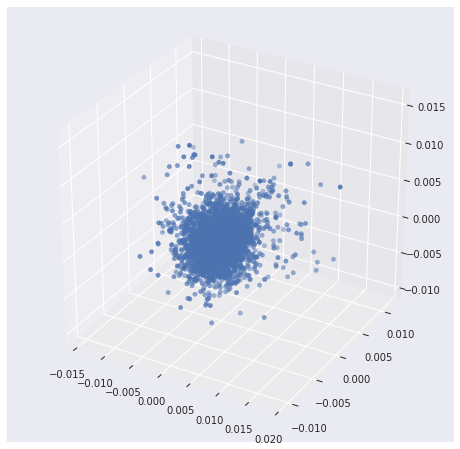

In [169]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

In [170]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [171]:
!gsutil cp gs://{BUCKET}/wals/data/* ./data

Copying gs://colaborative-filtering-agea/wals/data/batch_pred.txt...
Copying gs://colaborative-filtering-agea/wals/data/collab_mapped.csv...         
Copying gs://colaborative-filtering-agea/wals/data/collab_raw.csv...            
Copying gs://colaborative-filtering-agea/wals/data/items.csv...                 
\ [4 files][  1.4 GiB/  1.4 GiB]   75.3 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://colaborative-filtering-agea/wals/data/items_for_user...
Copying gs://colaborative-filtering-agea/wals/data/recommended-articles-mapped.csv...
Copying gs://colaborative-filtering-agea/wals/data/users.csv...                 
Copying gs://colaborative-filtering-agea/wals/data/users_for_item...            
- [8 files][  2.0 GiB/  2.0 GiB]   96.

In [172]:
!head data/items.csv

-ZPRbaCoz,7347
86sLs-KS_,6594
5I5k5XSIN,12072
QiH_Sd23-,15485
8_NNrmRnu,7332
FBODmTGeK,17156
pNlNYlDZl,14624
NYvFM_Vl4,16705
g6bEFs-iG,8156
ohG-9hNIk,11846


In [173]:
import csv
def create_mapping(filename):
  with open(filename, 'r') as csvfile:
    index_to_id = {}
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        index_to_id[row[1]] = row[0]
  return index_to_id

user_index_to_id = create_mapping('data/users.csv')
item_index_to_id = create_mapping('data/items.csv')

In [174]:
df = pd.read_csv('data/batch_pred.txt',  header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,1064,146,339,1296,1223,997,249,726,139,206
1,368,724,708,502,92,166,1525,2176,1124,1495
2,1463,1091,2214,1574,1308,2135,1827,820,4752,106
3,368,1091,502,92,708,1635,1974,1101,724,3624
4,337,129,206,1584,530,591,1142,1472,1018,1610


In [175]:
! head data/batch_pred.txt

1064,146,339,1296,1223,997,249,726,139,206
368,724,708,502,92,166,1525,2176,1124,1495
1463,1091,2214,1574,1308,2135,1827,820,4752,106
368,1091,502,92,708,1635,1974,1101,724,3624
337,129,206,1584,530,591,1142,1472,1018,1610
742,2933,1263,823,1913,3854,2517,3369,531,450
530,1091,206,1021,885,438,403,1978,1833,502
1974,635,1472,2864,4097,3866,1797,1913,1300,1610
823,2933,368,229,146,1064,742,450,969,1974
206,530,337,219,1810,1584,438,1021,1978,336


In [176]:
!ls data

batch_pred.txt	   items.csv			    users.csv
collab_mapped.csv  items_for_user		    users_for_item
collab_raw.csv	   recommended-articles-mapped.csv


In [177]:
for column in df.columns:
  df[column] = df[column].apply(lambda index: item_index_to_id[(str(index))])

In [178]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,iX3X6tNDk,-yn-SCmEb,xhaWlfFsJ,fjQb0n2tO,a0C9q_d-G,ZfCMSbdby,pJ3rJPH1F,I2Q3s7nJG,4r2NlCLxh,4TLebQRBG
1,0fYpABrXb,cGl_BoPtW,AYfFjDSci,Pzk2UKyZk,tlH9_skJ8,ehpLBo_zZ,kmpW4PTqM,JU-dc9R49,qANdidWel,-OzGpActr
2,VIpEwhPg5,YrpZD2B-o,Lo6wpP_2V,VwEQLGVKR,uNPEIzR2D,mQAcCfHZn,HPDkG-nj3,rgr8o29B8,QjuOAO14P,RCEykiWXb
3,0fYpABrXb,YrpZD2B-o,Pzk2UKyZk,tlH9_skJ8,AYfFjDSci,rvxNyTjoO,U4DXwSu00,i5YPUWFir,cGl_BoPtW,7RPwGsXL3
4,FmEAF-myl,6j10Sd240,4TLebQRBG,4-43qT9XU,Qkrub5W13,qGXixz8XL,zPV2Fu1r-,X5vYQVmaJ,wphIs88Xt,Rh4H0rD9G


In [179]:
users_index = [str(i) for i in range(len(df))]
df['user_id'] = map(lambda index: user_index_to_id.get(index),users_index)
df.head()

,0,1,2,3,4,5,6,7,8,9,user_id
0,iX3X6tNDk,-yn-SCmEb,xhaWlfFsJ,fjQb0n2tO,a0C9q_d-G,ZfCMSbdby,pJ3rJPH1F,I2Q3s7nJG,4r2NlCLxh,4TLebQRBG,3127735
1,0fYpABrXb,cGl_BoPtW,AYfFjDSci,Pzk2UKyZk,tlH9_skJ8,ehpLBo_zZ,kmpW4PTqM,JU-dc9R49,qANdidWel,-OzGpActr,1402547
2,VIpEwhPg5,YrpZD2B-o,Lo6wpP_2V,VwEQLGVKR,uNPEIzR2D,mQAcCfHZn,HPDkG-nj3,rgr8o29B8,QjuOAO14P,RCEykiWXb,4424328
3,0fYpABrXb,YrpZD2B-o,Pzk2UKyZk,tlH9_skJ8,AYfFjDSci,rvxNyTjoO,U4DXwSu00,i5YPUWFir,cGl_BoPtW,7RPwGsXL3,3604872
4,FmEAF-myl,6j10Sd240,4TLebQRBG,4-43qT9XU,Qkrub5W13,qGXixz8XL,zPV2Fu1r-,X5vYQVmaJ,wphIs88Xt,Rh4H0rD9G,3627874


In [180]:
df.to_csv('data/recommended-articles-mapped.csv',index=False)

In [181]:
!gsutil cp data/recommended-articles-mapped.csv gs://{BUCKET}/wals/data

Copying file://data/recommended-articles-mapped.csv [Content-Type=text/csv]...
\ [1 files][111.9 MiB/111.9 MiB]                                                
Operation completed over 1 objects/111.9 MiB.                                    


In [182]:
! head data/recommended-articles-mapped.csv

0,1,2,3,4,5,6,7,8,9,user_id
iX3X6tNDk,-yn-SCmEb,xhaWlfFsJ,fjQb0n2tO,a0C9q_d-G,ZfCMSbdby,pJ3rJPH1F,I2Q3s7nJG,4r2NlCLxh,4TLebQRBG,3127735
0fYpABrXb,cGl_BoPtW,AYfFjDSci,Pzk2UKyZk,tlH9_skJ8,ehpLBo_zZ,kmpW4PTqM,JU-dc9R49,qANdidWel,-OzGpActr,1402547
VIpEwhPg5,YrpZD2B-o,Lo6wpP_2V,VwEQLGVKR,uNPEIzR2D,mQAcCfHZn,HPDkG-nj3,rgr8o29B8,QjuOAO14P,RCEykiWXb,4424328
0fYpABrXb,YrpZD2B-o,Pzk2UKyZk,tlH9_skJ8,AYfFjDSci,rvxNyTjoO,U4DXwSu00,i5YPUWFir,cGl_BoPtW,7RPwGsXL3,3604872
FmEAF-myl,6j10Sd240,4TLebQRBG,4-43qT9XU,Qkrub5W13,qGXixz8XL,zPV2Fu1r-,X5vYQVmaJ,wphIs88Xt,Rh4H0rD9G,3627874
FOIVMpCUe,jSOes3ZLw,ianIQDGsG,WL4mkK9Qj,UfO-Rd7XS,o3t4wrYGC,QA68bAa0F,vDxOGq5SC,7tzu2526u,kZp2ESKJG,3862440
Qkrub5W13,YrpZD2B-o,4TLebQRBG,hGIz00KsH,P8IaYm87v,rVqUHQc1o,j7Ghm1MYi,ftUyKt9o-,N9N5qohc0,Pzk2UKyZk,4961169
U4DXwSu00,2d7eYMo6G,X5vYQVmaJ,9BrMu5499,g5XhCwDWD,B7fa_72A2,SfMuZ7XgD,UfO-Rd7XS,HnVdAnFc0,Rh4H0rD9G,3853869
WL4mkK9Qj,jSOes3ZLw,0fYpABrXb,oMcsgjCJB,-yn-SCmEb,iX3X6tNDk,FOIVMpCUe,kZp2ESKJG,C0iuarzIT,U4DXwSu00,4491186


In [183]:
! wc -l data/recommended-articles-mapped.csv

1086610 data/recommended-articles-mapped.csv


## validation

In [215]:
import google.datalab.bigquery as bq
USER_ID = 3127735  # 1402547 3127735

In [152]:
def get_articles_readed_by_user(user_id, number_of_articles):
  query = """ 
    SELECT 
      a.content_id,
      a.title,
      a.body, 
      a.section_1,
      a.tag_1
    FROM `AGEA_ASL.Dataset_A` a 
    RIGHT JOIN `AGEA_ASL.Dataset_B` b ON a.content_id = b.content_id 
    WHERE b.user_id = '{}'
    ORDER BY CAST(day_read AS DATETIME) DESC
    LIMIT {}
  """.format(user_id, number_of_articles)
  return bq.Query(query).execute().result().to_dataframe()

In [147]:
def get_content_by_ids(content_ids):
  query = """
    SELECT title,body, section_1, tag_1
    FROM `AGEA_ASL.Dataset_A` 
    WHERE content_id in ({})
    """.format(content_ids)
  return bq.Query(query).execute().result().to_dataframe()

In [210]:
# feminista -> 3127735 iX3X6tNDk,-yn-SCmEb,xhaWlfFsJ,fjQb0n2tO,a0C9q_d-G,ZfCMSbdby,pJ3rJPH1F,I2Q3s7nJG,4r2NlCLxh,4TLebQRBG
# 1402547 "'0fYpABrXb','cGl_BoPtW','AYfFjDSci','Pzk2UKyZk','tlH9_skJ8','ehpLBo_zZ','kmpW4PTqM','JU-dc9R49','qANdidWel','-OzGpActr'"
# 4424328 "'VIpEwhPg5','YrpZD2B-o','Lo6wpP_2V','VwEQLGVKR','uNPEIzR2D','mQAcCfHZn','HPDkG-nj3','rgr8o29B8','QjuOAO14P','RCEykiWXb'"
# 3627874 "'FmEAF-myl','6j10Sd240','4TLebQRBG','4-43qT9XU','Qkrub5W13','qGXixz8XL','zPV2Fu1r-','X5vYQVmaJ','wphIs88Xt','Rh4H0rD9G'"
# 3862440 "'FOIVMpCUe','jSOes3ZLw','ianIQDGsG','WL4mkK9Qj','UfO-Rd7XS','o3t4wrYGC','QA68bAa0F','vDxOGq5SC','7tzu2526u','kZp2ESKJG'"

In [216]:
get_articles_readed_by_user(USER_ID,50)

,content_id,title,body,section_1,tag_1
0,UWYjNfwij,Habla la mujer que escrachó al funcionario de ...,marianela sánchez está atravesando una situaci...,Sociedad,Abuso sexual
1,hGwBZkdff,Moria Casán destrozó a Carla Conte en Twitter,moria casán dio rienda suelta a su lengua kara...,Espectáculos - Fama,Moria Casán
2,v0n7eB9cZ,Los cinco libros feministas que recomienda The...,en su cuenta de instagram la actriz thelma fa...,Sociedad,Thelma Fardin
3,-wJnNTLDc,"Adrián Suar: ""Con Juan Darthés hice una evalua...",casi una semana después de la denuncia de viol...,Sociedad,Adrián Suar
4,LVHKuO85k,"Encabezados por Juan Grabois, militantes de la...",integrantes de la confederación de trabajadore...,Política,CTEP
5,tk6umSLMi,Habla la hermana del funcionario escrachado en...,soy periodista defiendo y trato de darle dif...,Sociedad,Abuso sexual
6,CBMbTNP7T,Vuelven a rechazar un pedido de Cristina Kirch...,la cámara federal penal porteña volvió a recha...,Política,Cristina Kirchner
7,QCUQMPIgi,El senador de La Cámpora denunciado por abuso ...,jorge romero el dirigente de la cámpora denun...,Política,La Cámpora
8,26RigoS4z,Verónica Llinás contó por qué el Colectivo de ...,el apoyo incondicional que el colectivo de act...,Espectáculos - Fama,Verónica Llinás
9,-wJnNTLDc,"Adrián Suar: ""Con Juan Darthés hice una evalua...",casi una semana después de la denuncia de viol...,Sociedad,Adrián Suar


In [214]:
get_content_by_ids("'iX3X6tNDk','-yn-SCmEb','xhaWlfFsJ','fjQb0n2tO','a0C9q_d-G','ZfCMSbdby','pJ3rJPH1F','I2Q3s7nJG','4r2NlCLxh','4TLebQRBG'")

,title,body,section_1,tag_1
0,Juan Darthés salió a defenderse después de la ...,horas después de que el colectivo actrices arg...,Sociedad,Juan Darthés
1,Habla el médico que le realizó la pericia físi...,lo hizo frente a cámara en el video mirácómon...,Sociedad,Juan Darthés
2,"Hicieron una encuesta sobre ""el peor president...",ni siquiera una retrospectiva sobre la vuelta ...,Política,Cristina Kirchner
3,Un amigo de la familia reveló cuál fue la reac...,desde que thelma fardin denunció a juan darthé...,Espectáculos - Fama,Juan Darthés
4,¿Qué hizo Juan Darthés durante la conferencia ...,había muchísima expectativa por saber qué iban...,Espectáculos - Fama,Juan Darthés
5,Nueva denuncia por violación contra Juan Darthés,cada día se complica más la situación para jua...,Espectáculos - Fama,Juan Darthés
6,Se filtró un mensaje que Juan Darthés le mandó...,tras ser denunciado por thelma fardin juan da...,Espectáculos - Fama,Juan Darthés
7,Caso Darthés: Gianella Neyra rompió el silencio,después de la contundente denuncia de thelma f...,Espectáculos - Fama,Juan Darthés
8,"Martín Bossi, tras el episodio con Andy Kusnet...",la visita de martín bossi a ph podemos h...,Espectáculos - Fama,Martín Bossi
9,Nicolás Repetto: polémica pregunta sobre Thelm...,nicolás repetto vuelve a estar en el ojo de la...,Espectáculos - Fama,Nicolás Repetto
